In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Let us create a grid first:

# X and Y coordinates
n = 5
_x = np.linspace(-1.05,1.05,n)
_y = np.linspace(-1.05,1.05,n)

# Differences
dx = (_x[1]-_x[0])/2
dy = (_y[1]-_y[0])/2

# Create bin edges:
ex = np.linspace(-1.05-dx, 1.05+dx, 101)
ey = np.linspace(-1.05-dy, 1.05+dy, 101)

# Creating a meshgrid:
x,y = np.meshgrid(_x,_y)
xy = np.column_stack([x.ravel(), y.ravel()])

# Creating a table:
XY = np.zeros((n,n))

In [5]:
# Creating a function that allows us to determine minimum distances between any point    
def minD(v1,v2):
    # For the sake of convention: let us let V1 to be to 'domain', it can be xy grid
    vector_differences = v1[:,None,:] - v2
    distances = np.linalg.norm(vector_differences,axis=2)
    minimum_distance = np.min(distances,axis=1)
    
    return distances,minimum_distance

class MinimumDistances:
    def __init__(self,grid_size, xlimit=1.2, ylimit=1.2):
        
        self.grid_size = grid_size
        self.xlimits = [-xlimit, xlimit]
        self.ylimits = [-ylimit, ylimit]
        
        # x and y steps
        self.x = np.linspace(-xlimit,xlimit,grid_size)
        self.y = np.linspace(-ylimit,ylimit,grid_size)
        
        # half step
        self.dx = (self.x[1]-self.x[0])/2
        self.dy = (self.y[1]-self.y[0])/2
        
        # Edges
        self.ex = np.linspace(-xlimit-dx, xlimit+dx, grid_size+1)
        self.ey = np.linspace(-ylimit-dy, ylimit+dy, grid_size+1)
        
        # Creating the meshgrid
        self.X , self.Y = np.meshgrid(self.x,self.y)
        self.XY = np.column_stack([self.X.ravel(), self.Y.ravel()])
        
        self.W = np.zeros((grid_size,grid_size))
    
    def addVector(self,V):
        if V.shape[1] != 2:
            raise AssertionError('The shape of the vector must be (x,2)')
        self.v2 = V
    
    def _getVectors(self,v1,v2):
        if type(v1) == type(None):
            v1 = self.XY
        if type(v2) == type(None):
            v2 = self.v2
        return v1,v2
    
    def vectorDistances(self,v1=None,v2=None):
        # General function to find minimum distances between vectors
        v1,v2 = self._getVectors(v1,v2)
        
        v_dif = v1[:,None,:] - v2
        distances = np.linalg.norm(v_dif,axis=2)
        return distances
    
    def minVectorDistance(self,v1=None,v2=None):
        
        v1,v2 = self._getVectors(v1,v2)
        distances = self.vectorDistances(v1,v2)
        min_distances = np.min(distances,axis=1)
        return min_distances
    
    def getMinDistIndex(self,v1=None,v2=None):
        # outputs the indexes where the difference is smallest between all v1 points to nearest v2 point
        v1,v2 = self._getVectors(v1,v2)
        distances = self.vectorDistances(v1,v2)
        index = np.where(distances == np.min(distances,axis=1).reshape(-1,1))[1]
        return index
    
    def plotV1V2(self, v1=None, v2=None):
        v1,v2 = self._getVectors(v1,v2)        
        plt.plot(v1[:,0],v1[:,1],'.')
        plt.plot(v2[:,0],v2[:,1],'.')
        plt.legend(['v1(Domain)','v2'])
    
    def plotMinimumDistances(self, v1=None, v2=None, include_maximum=True):
        v1,v2 = self._getVectors(v1,v2)
        
        self.plotV1V2(v1,v2)
        indexes = self.getMinDistIndex(v1,v2)
        minPoints = []
        for i in indexes:
            minPoints.append(v2[i])
            
        if include_maximum == True:
            plt.plot(1,0,'k--')
            
        for i,_ in enumerate(v1):
            N = np.concatenate([v1[i].reshape(1,-1),minPoints[i].reshape(1,-1)])
            plt.plot(N[:,0],N[:,1],'c--')
            
        plt.legend(['v1(domain)','v2','Maximum Minimum Distance','Min Distances'])

        if include_maximum == True:
            min_distances = self.minVectorDistance(v1,v2)
            maxMin = np.where(min_distances == max(min_distances))[0][0]
            N = np.concatenate([v1[maxMin].reshape(1,-1), minPoints[maxMin].reshape(1,-1)])
            minDistPlot = plt.plot(N[:,0],N[:,1],'k--')
        plt.grid()
        
    def plotGrid(self,XY=None):
        if type(XY) == type(None):
            XY = self.XY
        plt.plot(XY[:,0],XY[:,1],'.')
        plt.grid()
    
    def discretizeVector(self,v2):
        # This function will discretize a particular vector by doing the following:
        # Rounds it to the nearest "grid" point
        # Removes repeated values
        discretized_v2 = []
        XY = self.XY
        
        for v in v2:
            x1 = v[0]
            y1 = v[1]
            
            for i,_ in enumerate(self.ex[:-1]):
                if (x1 >= self.ex[i]) and (x1 <= self.ex[i+1]):
                    x_coord = self.x[i]
            for j,_ in enumerate(self.ey[:-1]):
                if (y1 >= self.ey[j]) and (y1 <= self.ey[j+1]):
                    y_coord = self.y[j]
            discretized_v2.append(XY[(XY[:,0] == x_coord) & (XY[:,1] == y_coord)])
            del x_coord, y_coord
            
        discretized_v2 = np.vstack(discretized_v2)
        self.v2 = np.unique(discretized_v2,axis=0)
        return self.v2

    def _reduceGridComplexity_Odd(self,XY=None,output=False):
        if type(XY) == type(None):
            XY = self.XY
        out = []
        for i in range(XY.shape[0]):
            if i%2==0:
                out.append(i)
                continue
        out = np.array(out)
        self.XY_reduced = XY[out]
        if output == True:
            return XY[out]
        
    def _reduceGridComplexity_Even(self,XY=None,output=False):
        if type(XY) == type(None):
            XY = self.XY
        out = []
        n = int(np.sqrt(XY.shape[0]))
        switch = False

        for i in range(XY.shape[0]):
            if switch == False:
                if i%2==0:
                    out.append(i)
            if switch == True:
                if i%2 != 0:
                    out.append(i)
            if (i+1) % n == 0:
                switch = (switch == False)
        out = np.array(out)
        self.XY_reduced = XY[out]
        if output == True:
            return XY[out]
    
    def reduceGridComplexity(self,XY=None, grid_type='mesh'):
        if type(XY) == type(None):
            XY = self.XY
        is_odd = (int(np.sqrt(XY.shape[0])) % 2) != 0
        
        if grid_type == 'mesh':
            if is_odd:
                return self._reduceGridComplexity_Odd(XY,output=True)
            return self._reduceGridComplexity_Even(XY,output=True)
        
        if grid_type == 'vertical':
            if is_odd:
                return self._reduceGridComplexity_Even(XY,output=True)
            return self._reduceGridComplexity_Odd(XY,output=True)
            
        
        
    
            
 
        
        

In [13]:
help

Type help() for interactive help, or help(object) for help about object.

Help on package numpy:

NAME
    numpy

DESCRIPTION
    NumPy
    =====
    
    Provides
      1. An array object of arbitrary homogeneous items
      2. Fast mathematical operations over arrays
      3. Linear Algebra, Fourier Transforms, Random Number Generation
    
    How to use the documentation
    ----------------------------
    Documentation is available in two forms: docstrings provided
    with the code, and a loose standing reference guide, available from
    `the NumPy homepage <https://numpy.org>`_.
    
    We recommend exploring the docstrings using
    `IPython <https://ipython.org>`_, an advanced Python shell with
    TAB-completion and introspection capabilities.  See below for further
    instructions.
    
    The docstring examples assume that `numpy` has been imported as ``np``::
    
      >>> import numpy as np
    
    Code snippets are indicated by three greater-than signs::
    
      >>> x = 42
      >>> x = x + 1
    
    Use the built-in ``help`` functi

In [4]:
a = MinimumDistances(6)
xy_red = a.reduceGridComplexity()

NameError: name 'MinimumDistances' is not defined

In [ ]:
a.plotGrid(a.XY)
a.plotGrid(xy_red)
plt.grid()

In [63]:
def reduceGridComplexity_Odd(XY):
    out = []
    for i in range(XY.shape[0]):
        if i%2==0:
            out.append(i)
            continue
    out = np.array(out)
    return XY[out]

def reduceGridComplexity_Even(XY):
    out = []
    n = int(np.sqrt(XY.shape[0]))
    switch = False
    
    for i in range(XY.shape[0]):
        if switch == False:
            if i%2==0:
                out.append(i)
        if switch == True:
            if i%2 != 0:
                out.append(i)
        if (i+1) % n == 0:
            switch = (switch == False)
    print(out)
    out = np.array(out)
    return XY[out]
        

In [29]:
def reduceGridComplexity(XY):
    out = []
    for i in range(XY.shape[0]):
        if i%2==0:
            out.append(i)
            continue
    out = np.array(out)
    return XY[out]
        

In [10]:
help(MinimumDistances)

Help on class MinimumDistances in module __main__:

class MinimumDistances(builtins.object)
 |  MinimumDistances(grid_size, xlimit=1.2, ylimit=1.2)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, grid_size, xlimit=1.2, ylimit=1.2)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  addVector(self, V)
 |  
 |  discretizeVector(self, v2)
 |  
 |  getMinDistIndex(self, v1=None, v2=None)
 |  
 |  minVectorDistance(self, v1=None, v2=None)
 |  
 |  plotGrid(self, XY=None)
 |  
 |  plotMinimumDistances(self, v1=None, v2=None, include_maximum=True)
 |  
 |  plotV1V2(self, v1=None, v2=None)
 |  
 |  reduceGridComplexity(self, XY=None, grid_type='mesh')
 |  
 |  vectorDistances(self, v1=None, v2=None)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defin

In [11]:
help(np)

Help on package numpy:

NAME
    numpy

DESCRIPTION
    NumPy
    =====
    
    Provides
      1. An array object of arbitrary homogeneous items
      2. Fast mathematical operations over arrays
      3. Linear Algebra, Fourier Transforms, Random Number Generation
    
    How to use the documentation
    ----------------------------
    Documentation is available in two forms: docstrings provided
    with the code, and a loose standing reference guide, available from
    `the NumPy homepage <https://numpy.org>`_.
    
    We recommend exploring the docstrings using
    `IPython <https://ipython.org>`_, an advanced Python shell with
    TAB-completion and introspection capabilities.  See below for further
    instructions.
    
    The docstring examples assume that `numpy` has been imported as ``np``::
    
      >>> import numpy as np
    
    Code snippets are indicated by three greater-than signs::
    
      >>> x = 42
      >>> x = x + 1
    
    Use the built-in ``help`` functi

In [73]:
b.reduceGridComplexity()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

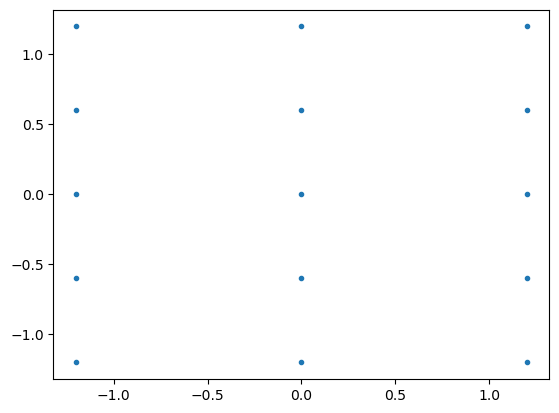

In [68]:
plt.plot(xy_c[:,0],xy_c[:,1],'.')

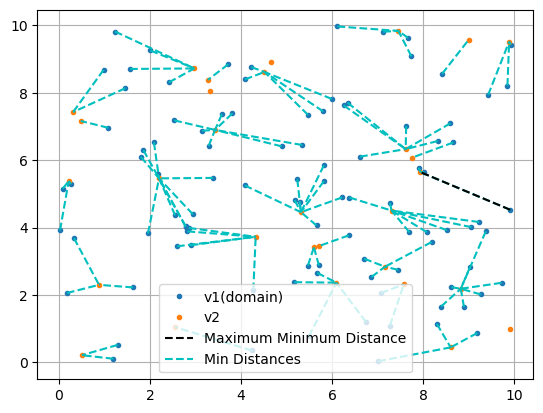

In [272]:
a.plotMinimumDistances(v1,v2)

In [288]:
n = 100
x1 = np.random.random(n)*np.sign(np.random.randn(n))
y1 = np.random.random(n)*np.sign(np.random.randn(n))

v_check = np.column_stack([x1,y1])*1.19
v_check
a_test = MinimumDistances(grid_size=20)
a_test.discretizeVector(v_check)
a_test.plotV1V2(v1=None, v2=a_test.discretizeVector(v_check))

array([[ 0.22942479,  1.15201883],
       [-0.37142201, -0.58961418],
       [ 0.1557038 , -0.07779136],
       [ 0.40326473,  1.03625703],
       [ 0.99725583,  0.51484079],
       [ 0.62196495,  1.1488214 ],
       [-0.09507137, -0.3858753 ],
       [ 0.61011769, -0.55289735],
       [ 0.52829483,  0.71765352],
       [-0.91313788,  0.31162161],
       [-1.17086802, -1.15644239],
       [-0.13591053,  0.50778177],
       [ 0.8187688 ,  0.46498545],
       [-1.04566708,  0.16365958],
       [ 1.09430671, -0.49009515],
       [-0.06196048, -0.41867854],
       [-0.40355534,  0.31464445],
       [-0.53754241, -0.54774394],
       [ 0.62707507, -0.38017756],
       [ 0.91246269, -0.91417192],
       [-0.23133412,  0.64494776],
       [ 1.17181884, -0.56206909],
       [ 0.39208623, -0.20784793],
       [ 0.39159981,  0.57649055],
       [ 0.29933037, -0.03140008],
       [ 0.84819123,  0.49339113],
       [-0.43708475,  0.60656364],
       [-0.90304081,  0.00422276],
       [-0.63228595,

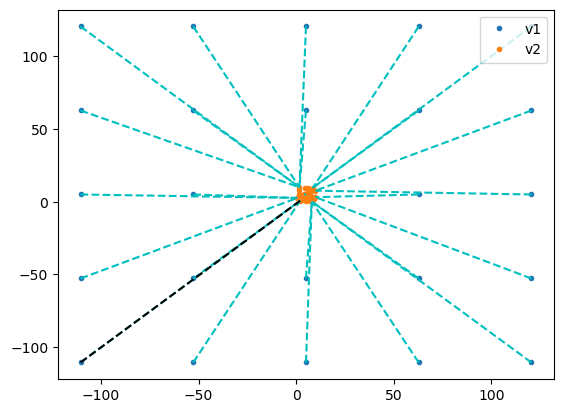

In [71]:
plt.plot(v1[:,0],v1[:,1],'.')
plt.plot(v2[:,0],v2[:,1],'.')

indexes = np.where(distances==np.min(distances,axis=1).reshape(-1,1))[1]

minPoints = []
for i in indexes:
    minPoints.append(v2[i])
    
for i,_ in enumerate(v1):
    N = np.concatenate([v1[i].reshape(1,-1),minPoints[i].reshape(1,-1)])
    plt.plot(N[:,0],N[:,1],'c--')

# What if we are ONLY focused on the maximum Minimum distance?
maxMin = np.where(minimum_distance == max(minimum_distance))[0][0]
N = np.concatenate([v1[maxMin].reshape(1,-1), minPoints[maxMin].reshape(1,-1)])
plt.plot(N[:,0],N[:,1],'k--')

plt.legend(['v1','v2'])

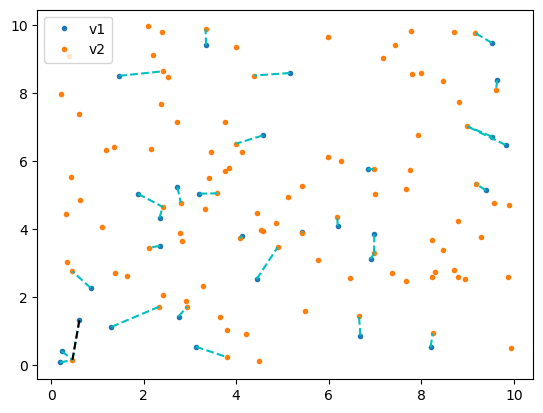

In [29]:
plt.plot(v1[:,0],v1[:,1],'.')
plt.plot(v2[:,0],v2[:,1],'.')

indexes = np.where(distances==np.min(distances,axis=1).reshape(-1,1))[1]

minPoints = []
for i in indexes:
    minPoints.append(v2[i])
    
for i,_ in enumerate(v1):
    N = np.concatenate([v1[i].reshape(1,-1),minPoints[i].reshape(1,-1)])
    plt.plot(N[:,0],N[:,1],'c--')

# What if we are ONLY focused on the maximum Minimum distance?
maxMin = np.where(minimum_distance == max(minimum_distance))[0][0]
N = np.concatenate([v1[maxMin].reshape(1,-1), minPoints[maxMin].reshape(1,-1)])
plt.plot(N[:,0],N[:,1],'k--')

plt.legend(['v1','v2'])

In [13]:
xy.shape

(25, 2)

In [80]:
a = Yer()

In [81]:
a.y

array([[-1.05 , -1.05 , -1.05 , -1.05 , -1.05 ],
       [-0.525, -0.525, -0.525, -0.525, -0.525],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.525,  0.525,  0.525,  0.525,  0.525],
       [ 1.05 ,  1.05 ,  1.05 ,  1.05 ,  1.05 ]])

In [86]:
a = MinimumDistances(grid_size=5)

In [89]:
a.XY.shape

(25, 2)